In [1]:
import os
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import matplotlib.patches as patches
import matplotlib.patches as patches
from skimage.transform import resize
from tqdm import tqdm
import glob

In [121]:
# video config
WIDTH = 200
HEIGHT = 200
DIM = 3
X_DIM = 3

WIDTH_FACTOR = 800 // WIDTH
HEIGHT_FACTOR = 600 // HEIGHT

In [3]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.9, alpha=0.99):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.spectral_radius = spectral_radius
        self.alpha = alpha

        self.W_in = np.random.rand(reservoir_size, input_size + 1) - 0.5  # bias term
        self.W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5 # bias term
        self.W_out = np.random.rand(output_size, reservoir_size) - 0.5    # bias term

        self.W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W_res)))

    def train(self, X_train, y_train, transient=100):
        X_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)  # Add bias term to input
        X_res = np.zeros((len(X_train), self.reservoir_size))
        x = np.zeros(self.reservoir_size)

        for t in range(len(X_train)):
            u = X_train[t]
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, x))
            if t > transient:
                X_res[t] = x

        self.W_out = np.dot(np.linalg.pinv(X_res[transient:]), y_train[transient:])

    def predict(self, X_test):
        X_test = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)  # Add bias term to input
        X_res = np.zeros((len(X_test), self.reservoir_size))
        x = np.zeros(self.reservoir_size)

        for t in range(len(X_test)):
            u = X_test[t]
            x = (1 - self.alpha) * x + self.alpha * np.tanh(np.dot(self.W_in, u) + np.dot(self.W_res, x))
            X_res[t] = x

        return np.dot(X_res, self.W_out)
    
    def identity(self, x):
        return softmax(x)

In [4]:
def draw_bounding_boxes_from_array(video_path, bounding_boxes, output_video_path):
    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create a VideoWriter object for AVI format
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Read each frame, draw bounding boxes, and write to output video
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Extract coordinates for the current frame
        if frame_count < len(bounding_boxes):
            x, y = bounding_boxes[frame_count]
            x, y = int(x), int(y)
            width, height = 30, 30  # Assumed width and height

            # Draw bounding box
            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)

        # Write the frame to the output video
        out.write(frame)

        frame_count += 1

    # Release video capture and writer objects
    cap.release()
    out.release()

    print(f"Bounding boxes added and new video saved to: {output_video_path}")

def read_png_image(file_path, name, i):

    file_name = os.path.basename(file_path)
    image_array = random_augment(file_path)
    #image_array = resize(image_array, (HEIGHT , WIDTH), anti_aliasing=True)

    number = int(file_name.split("_")[1].split(".")[0])
    df = pd.read_csv(f'assets/preprocessed_bb_coordinates/moving_{name}_{i}.csv')
    x = df['X-coordinate']
    y = df['Y-coordinate']

    # Get object coordinates
    x_coord = int(x[number] // WIDTH_FACTOR)
    y_coord = int(y[number] // HEIGHT_FACTOR)

    image_array = crop_image(image_array, x_coord, y_coord)

    return image_array, x_coord, y_coord

def plot_image(img, bb, save_path):

    fig, ax = plt.subplots()

    plt.imshow(img)
    x, y = (bb[0]-30)//WIDTH_FACTOR, (bb[1]-30)//HEIGHT_FACTOR
    rect = patches.Rectangle((x, y), 10, 10, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Save the figure instead of showing it
    plt.savefig(save_path)
    plt.close()  # Close the figure to free memory

def zoom(image, scale=(1, 1.3)):
  zoom = iaa.Affine(scale=scale)
  image = zoom.augment_image(image)
  return image

def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.08, 0.08), "y":(-0.08, 0.08)})
  image = pan.augment_image(image)
  return image

def img_random_brightness(image):
  # As of experience models recats better to darker immages
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

def random_augment(image):
  
  image = mpimg.imread(image)
  #if np.random.rand() < 0.5:
  #  image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  
  return image

def crop_image(image_array, x, y, output_size=(201, 201)):
    
    # Define the cropping box based on the object's location and the offset
    left = max(0, x - 100)
    upper = max(0, y - 100)
    right = min(WIDTH, x + 100)
    lower = min(HEIGHT, y + 100)
    
    # Crop the image array
    cropped_image_array = image_array[upper:lower, left:right]
    
    # Pad the cropped image to ensure consistent size
    pad_height = max(0, output_size[0] - cropped_image_array.shape[0])
    pad_width = max(0, output_size[1] - cropped_image_array.shape[1])
    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad
    cropped_image_array = np.pad(cropped_image_array, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')
    
    # Return the cropped and padded image array
    return cropped_image_array

# MNIST

### Training

In [26]:
# Load MNIST data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X = X / 255.0  # Normalize pixel values to range [0, 1]
X = np.array(X)
y = OneHotEncoder().fit_transform(y.values.reshape(-1, 1)).toarray()  # One-hot encode labels

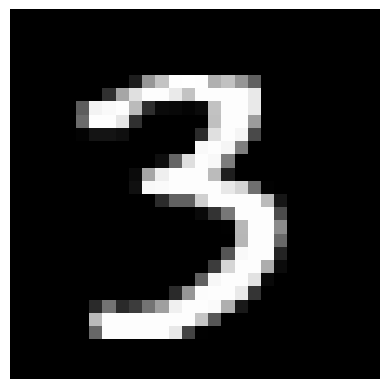

In [30]:
import matplotlib.pyplot as plt

def plot_image(image_array):
    """
    Plot an image from a NumPy array.
    
    Parameters:
        image_array (numpy.ndarray): The image array to be plotted.
    """
    plt.imshow(image_array.reshape(HEIGHT, WIDTH), cmap='gray')  # Assuming grayscale image, change cmap for color images
    plt.axis('off')  # Turn off axis labels
    plt.show()


In [61]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70000, 784)
y shape: (70000, 10)


In [62]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Initialize and train ESN
input_size = X_train.shape[1]
reservoir_size = 1000
output_size = 10
esn = ESN(input_size, reservoir_size, output_size)
esn.train(X_train, y_train)

### Prediction

In [64]:
# Predict and evaluate
predictions = esn.predict(X_test)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy:", accuracy)

Accuracy: 0.9204285714285714


### Prediction on 1 image

In [ ]:
print("Ground truth label:", y_test[90])
print("Predicted label:", predictions[45])

In [ ]:
prediction_softmax = softmax(predictions[90])
print("Predicted probabilities:  ", np.argmax(prediction_softmax))
print("ground truth label:       ", np.argmax(y_test[90]))

# Shapes (External data)

In [124]:
# Define your folders
main_folder = 'assets/shapes/geometric shapes dataset'
Circle = os.path.join(main_folder, 'Circle')
Square = os.path.join(main_folder, 'Square')
Triangle = os.path.join(main_folder, 'Triangle')
folders = [Circle, Square, Triangle]

# Function to load images from a folder
def load_images(folder, label):
    images = []
    labels = []
    f = 0
    for filename in tqdm(os.listdir(folder), desc=f"Loading images from {folder}"):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = Image.open(os.path.join(folder, filename))
            # Resize image to a fixed size if necessary
            img = img.resize((HEIGHT, WIDTH))
            img = np.array(img)
            img = img[40:160, 40:160, :]
            images.append(img)
            labels.append(label)

        f += 1
        if f == 5000:
            break
    return images, labels

# Load images and labels
X = []
y = []
n = 0
for folder in folders:
    images, labels = load_images(folder, n)
    X.extend(images)
    y.extend(labels)
    n += 1

# get unique labels
unique_labels = np.unique(y)
print("Unique labels:", unique_labels)

# Convert to numpy array
X = np.array(X)
X = np.reshape(X, (len(X), (120*120), DIM))
X_gray = np.dot(X[...,:DIM], np.array([0.2989, 0.5870, 0.1140]))
X = np.expand_dims(X_gray, axis=-1)
X = X[:, :, 0]
print(X.shape)
X = X / 255.0
#X = pd.DataFrame(X)
y = np.array(y)

# Perform one-hot encoding on labels
y_encoded = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()
print(y_encoded.shape)

Loading images from assets/shapes/geometric shapes dataset/Circle:   0%|          | 0/10000 [00:00<?, ?it/s]

Loading images from assets/shapes/geometric shapes dataset/Circle:  50%|████▉     | 4999/10000 [00:02<00:02, 1746.74it/s]
Loading images from assets/shapes/geometric shapes dataset/Square:  50%|████▉     | 4999/10000 [00:02<00:02, 2042.47it/s]
Loading images from assets/shapes/geometric shapes dataset/Triangle:  50%|████▉     | 4999/10000 [00:02<00:02, 1887.68it/s]


Unique labels: [0 1 2]
(15000, 14400)
(15000, 3)


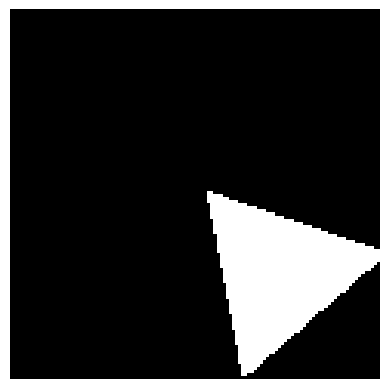

In [130]:
import matplotlib.pyplot as plt

def plot_image(image_array):
    """
    Plot an image from a NumPy array.
    
    Parameters:
        image_array (numpy.ndarray): The image array to be plotted.
    """
    plt.imshow(image_array.reshape(120, 120), cmap='gray')  # Assuming grayscale image, change cmap for color images
    plt.axis('off')  # Turn off axis labels
    plt.show()

plot_image(X[14000])


In [131]:
X.shape, y_encoded.shape

((15000, 14400), (15000, 3))

In [132]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

In [137]:
# Initialize and train ESN
input_size = X_train.shape[1]
reservoir_size = 2000
output_size = y_train.shape[1]
esn = ESN(input_size, reservoir_size, output_size)
esn.train(X_train, y_train)

In [138]:
# Predict and evaluate
predictions = esn.predict(X_test)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy:", accuracy)

Accuracy: 0.478


In [11]:
TEST = 470
print("Ground truth label:", y_test[TEST])
print("Predicted label:   ", predictions[TEST])

Ground truth label: [1. 0. 0.]
Predicted label:    [ 0.54312134  0.48158646 -0.02485657]


In [12]:
prediction_softmax = softmax(predictions[TEST])
print("Predicted probabilities:  ", np.argmax(prediction_softmax))
print("ground truth label:       ", np.argmax(y_test[TEST]))

Predicted probabilities:   0
ground truth label:        0


# Shapes (Original frames)

In [ ]:
# Load video frames
shapes = {'circle':3, 'rect':3}
#shapes = {'circle':1}
X, y = [], []
n = 0

for j in shapes.keys():
    print(f'Preprocessing images for shape: {j}')
    for i in tqdm(range(shapes[j]), desc='Preprocessing images...'):
        img_path = os.path.join(os.getcwd(), f'assets/original_frames/moving_{j}_{i}')
        files = glob.glob(os.path.join(img_path, '*.png'))
        sorted_files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

        for filepath in sorted_files:
            image_array, _, _ = read_png_image(filepath, j, i)

            X.append(image_array)
            y.append(n)
    n += 1

print('Preprocessing done!\n')

In [ ]:
X, y = np.array(X), np.array(y)
X = np.reshape(X, (len(X), HEIGHT*WIDTH, DIM))
X_gray = np.dot(X[...,:DIM], [0.2989, 0.5870, 0.1140])
X = np.expand_dims(X_gray, axis=-1)

y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()  # One-hot encode labels

In [ ]:
# data splitting
n_samples = len(X)
train_idx = int(n_samples * 0.95)
X_train, X_test = X[:train_idx,...], X[train_idx:, ...]
y_train, y_test = y[:train_idx], y[train_idx:]

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
# Initialize and train ESN
input_size = X_train.shape[1]
reservoir_size = 1000
output_size = 3
esn = ESN(input_size, 
          reservoir_size, 
          output_size, 
          spectral_radius=0.9, 
          alpha=0.98)

In [ ]:
esn.train(np.array(X_train[:, :, 0]).reshape(len(X_train), -1), np.array(y_train))

In [ ]:
# Predict and evaluate
predictions = esn.predict(np.array(X_test[:, :, 0]).reshape(len(X_test), -1))
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print("Accuracy:", accuracy)

In [ ]:
TEST = 4
print("Ground truth label:", y_test[TEST])
print("Predicted label:", predictions[TEST])

In [ ]:
prediction_softmax = softmax(predictions[TEST])
print("Predicted probabilities:  ", np.argmax(prediction_softmax))
print("ground truth label:       ", np.argmax(y_test[TEST]))